In [1]:
# Data processing/formatting
from sklearn.preprocessing import MinMaxScaler
from seqprops import SequentialPropertiesEncoder
from sklearn.model_selection import train_test_split
from tools import one_hot_encode_list, one_hot_decode_list, one_hot_decode, softmax_beta

# for building vae model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Bidirectional, Conv1D, Dropout, RepeatVector, TimeDistributed, Lambda, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

# classic required packages
import os
import random
import pandas as pd
import numpy as np
from pylab import rcParams
import importlib
import importlib.resources

# packages for graphics
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

In [2]:
file = 'amp.csv'
df = pd.read_csv(file)

peptides = df.loc[:, 'sequence'].values
peptides_type = df.loc[:, 'label'].values
print(peptides)
print(peptides_type)

# Determine the length of the longest sequence
max_peptide_len = 0
for peptide in peptides:
    max_peptide_len = max(len(peptide), max_peptide_len)
print("Max peptide length: ", max_peptide_len)

['GEP' 'QHP' 'YLRF' ...
 'MGSPEKLRPSDFSKSFLISSIRFAMSFSSFELYSACSSLIRVSSPTMAET'
 'MLLPATMSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQAGES'
 'GATIKKCVVDVKLSKPCTFQECQPLCLQKYNGNGLCPGDDNNICACVYNC']
[0 0 0 ... 0 0 1]
Max peptide length:  50


In [3]:
(x_train_peptides, x_test_peptides, y_train_peptide_types, y_test_peptide_types) = train_test_split(peptides, peptides_type, test_size=0.2, random_state=42)
x_train_onehotencoded = one_hot_encode_list(x_train_peptides)
x_train_onehotencoded = x_train_onehotencoded.reshape((7527, 50, 21))
x_test_onehotencoded = one_hot_encode_list(x_test_peptides)
x_test_onehotencoded = x_test_onehotencoded.reshape((1882, 50, 21))
print(x_train_onehotencoded.shape, x_test_onehotencoded.shape)

(7527, 50, 21) (1882, 50, 21)


In [4]:
onehotencode_shape = x_train_onehotencoded.shape[1:]
print(onehotencode_shape)

print(x_train_peptides.shape)


(50, 21)
(7527,)


In [5]:
# Function for plotting latent space from encoded test data
def plot_input_data(encoder, x_data, y_data, title):
    z_input, _ = encoder.predict(x_data)
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
# Function for plotting latent space from reconstructed decoder data
def plot_reconstructed_data(encoder, decoder, x_data, y_data, title):
    z_input, _ = encoder.predict(x_data)
    reconstructed_input = decoder.predict(z_input)
    reconstruced_z_input, _ = encoder.predict(reconstructed_input)
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(reconstruced_z_input[indices, 0], reconstruced_z_input[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')

    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title(title)
    plt.legend()
    plt.show()
    
title_enc_training_data = "Podaci za trening enkodirani u latentni prostor"
title_enc_test_data = "Podaci za test enkodirani u latentni prostor"
title_recon_enc_training_data = "Rekonstruirani trening podaci enkodirani u latentni prostor"
title_recon_enc_test_data ="Rekonstruirani testni podaci enkodirani u latentni prostor"

In [7]:
def create_seq_encoder_model(input_shape, latent_dim=2, lstm_cells=64):
    inp = Input(shape=input_shape, name="input_1_enc")
    x = LSTM(lstm_cells, unroll=True, name="lstm_enc")(inp)
    z = Dense(32, activation='relu', name="output_dense_enc")(x)
    z_mean = Dense(latent_dim)(z)
    z_log_sigma = Dense(latent_dim)(z)
    
    encoder_model = Model(inputs=inp, outputs=[z_mean, z_log_sigma], name="encoder")
    return encoder_model

In [8]:
def create_seq_decoder_model(input_shape, latent_dim=2, lstm_cells=64):
    model_input = Input(shape=(latent_dim,), name="input_1_dec")
    x = RepeatVector(input_shape[0])(model_input)
    x = LSTM(lstm_cells, unroll=True, name="lstm_dec", return_sequences=True)(x)
    out = TimeDistributed(Dense(input_shape[1]))(x)
#    softmax
    last_dense = Activation(softmax_beta)(out)
    
    decoder_model = Model(inputs=model_input, outputs=last_dense, name="decoder")
    return decoder_model

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder     
        self.kl_scalling_factor = 0.0
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_seed(self, seed):
        self.random_seed = seed
        tf.random.set_seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)
        random.seed(seed)
    
    # Sampling from latent space
    def sampling(self, args):
        z_mean, z_log_sigma = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_sigma) * epsilon

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_sigma = self.encoder(data)
            z = Lambda(self.sampling)([z_mean, z_log_sigma])
            reconstruction = self.decoder(z)
            
            kl_loss =  tf.keras.backend.get_value(self.beta_x) * -1 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
            )
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(data, reconstruction), axis=1
                )
            )
            
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x = data[0]
        z_mean, z_log_sigma = self.encoder(data)
        z = Lambda(self.sampling)([z_mean, z_log_sigma])
        reconstructed_x = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=1)
            )

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mean_squared_error(data, reconstructed_x), axis=1
            )
        )
        total_loss = reconstruction_loss + kl_loss
        self.compiled_metrics.update_state(x, reconstructed_x)

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results

In [10]:
class LossCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super(LossCallback, self).__init__()
        model.beta_x = tf.Variable(1.0, trainable=False, name='weight1', dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs=None):
#         tf.keras.backend.set_value(self.model.beta_x, tf.constant(0.5) * epoch)
#         kl_scaling_schedule = [0.5, 0.6, 0.7, 0.8, 1, 1.3, 1.5, 1.7, 1.7, 1.7, 1.7, 1.7]
        kl_scaling_schedule = [2500, 3000, 3500, 2000, 1500, 1000, 500, 1.7, 1.7, 1.7, 1.7, 1.7]
        if epoch < len(kl_scaling_schedule):
            scalling_factor = kl_scaling_schedule[epoch]
        tf.keras.backend.set_value(self.model.beta_x, scalling_factor)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['beta_x'] = tf.keras.backend.get_value(self.model.beta_x)
        print(logs['beta_x'])

In [11]:
encoder = create_seq_encoder_model(input_shape=onehotencode_shape)
encoder.summary()
decoder = create_seq_decoder_model(input_shape=onehotencode_shape, latent_dim=2)
decoder.summary()
vae = VAE(encoder, decoder)
vae.set_seed(31)

callback = LossCallback(vae)
vae.compile(optimizer=keras.optimizers.Adam())

# tensorboard --logdir=C:\Users\StarLord\Documents\Diplomski\VAEs\tmp\onehot-vae\
# TensorBoard(log_dir='C:\\Users\\StarLord\\Documents\\Diplomski\\VAEs\\tmp\\onehot-vae')

# Thrid VAE model - with one-hot encoded data randomized data
# x_train_onehotencoded, x_test_onehotencoded, y_train_peptide_types, y_test_peptide_types
es = EarlyStopping(patience=5, verbose=1, min_delta=0.01, monitor='loss', mode='auto', restore_best_weights=True)
vae.fit(x_train_onehotencoded, batch_size=128, epochs=5, 
        validation_data=(x_test_onehotencoded, None), 
        shuffle=False,
        callbacks=[es, callback])

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1_enc (InputLayer)       [(None, 50, 21)]     0           []                               
                                                                                                  
 lstm_enc (LSTM)                (None, 64)           22016       ['input_1_enc[0][0]']            
                                                                                                  
 output_dense_enc (Dense)       (None, 32)           2080        ['lstm_enc[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 2)            66          ['output_dense_enc[0][0]']       
                                                                                            

236/236 [==============================] - 6s 11ms/step


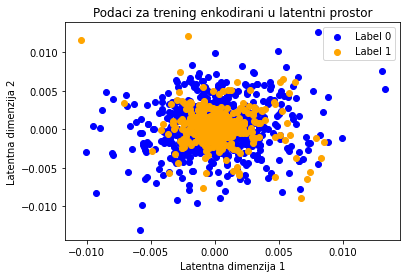

236/236 [==============================] - 2s 9ms/step


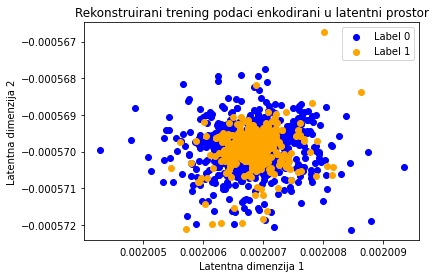

59/59 [==============================] - 1s 9ms/step


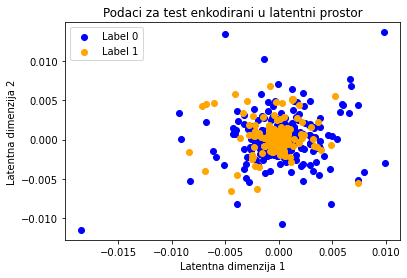

59/59 [==============================] - 0s 6ms/step


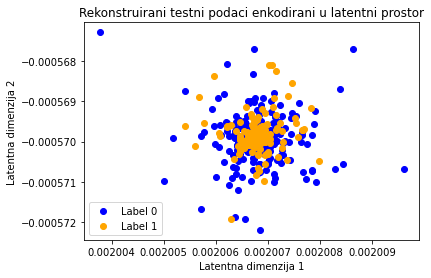

In [12]:
# x_train_onehotencoded, x_test_onehotencoded, y_train_peptide_types, y_test_peptide_types
# train data in latent space
plot_input_data(vae.encoder, x_train_onehotencoded, y_train_peptide_types, title_enc_training_data)
# reconstructed train data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_train_onehotencoded, y_train_peptide_types, title_recon_enc_training_data)
# test data in latent space
plot_input_data(vae.encoder, x_test_onehotencoded, y_test_peptide_types, title_enc_test_data)
# reconstructed test data in latent space
plot_reconstructed_data(vae.encoder, vae.decoder, x_test_onehotencoded, y_test_peptide_types, title_recon_enc_test_data)

In [36]:
# From decimal to 0 or 1, by treshold
# threshold = 0.5
# decoded_sequences_binary = (decoded_data > threshold).astype(int)
# (7527, 50, 21) (1882, 50, 21)
np.set_printoptions(threshold=1000)

enc_pred, _ = vae.encoder.predict(x_test_onehotencoded)
decoded_data = vae.decoder.predict(enc_pred)

# Testing predicted data
# Initialize an array to store the binary sequences
decoded_sequences_binary = []
# Loop through first amino acid position
for position_probs in decoded_data[0]:
    closest_to_1_index = np.argmax(np.abs(position_probs))
    binary_sequence = np.zeros_like(position_probs)
    binary_sequence[closest_to_1_index] = 1
    decoded_sequences_binary.append(binary_sequence)
    
total_sum = sum(decoded_sequences_binary[0])
# Print the total sum
print("The sum of all numbers in the array is:", total_sum)
# print(decoded_sequences_binary)  
peptides_decoded = one_hot_decode(decoded_sequences_binary)
print("Firs peptide decoded:", peptides_decoded)

# Loop through all amino acid position
decoded_data_peptide = []
decoded_data_peptides = []
for sequence_array in decoded_data:
    for seq in sequence_array:
        closest_to_1_index = np.argmax(np.abs(seq))
        binary_sequence = np.zeros_like(seq)
        binary_sequence[closest_to_1_index] = 1
        decoded_data_peptide.append(binary_sequence)
        converted = np.array(decoded_data_peptide)
        # [0,0,0,0,1]         
    decoded_data_peptides.append(converted) 
    # [[0,0,1], [0,0,1]]     
    decoded_data_peptide = []

print("AAAAAAAAA")
print(decoded_data_peptides[0])

final = one_hot_decode_list(decoded_data_peptides)
print(final)
print(len(final))

59/59 [==============================] - 1s 9ms/step
The sum of all numbers in the array is: 1.0
Firs peptide decoded: LLL                                               
AAAAAAAAA
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
['LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL                                               ', 'LLL           